In [1]:
#%gui osx

import random as rand
import pygame as pg

from genelife import *

## Graphics notes

This notebook uses the pygame interface.

It pops up a pygame window (labeled "Gene Life"), which must be moved to the side to see the notebook.

To stop the simulation mid-stream, you can click on the pygame window, click in the window. 

Color is currently a 32 bit hash of the 64 bit gene value.

To change resolution (size of array, only powers of 2 allowed): 
* change `subgenelife.c` line 23 (`log2N`) and rebuild c lib
* change `genlife.py` line 10 (also `log2N`)
* change `Width` and `Height` below.

## Initialization

See additional discussion in the [genelife wiki](https://github.com/js1200/genelife/wiki/Probability-parameters-in-genelife).

The code determining the effect of genes on birth, and the mutation of genomes is currently on lines 229-242 of `subgenelife.c`.
* param `rulemod   == 1` => genetically alteration of GOL rule kicks in
Possible schemes for chosing replication
* param `repscheme == 0` => replication ancestor for 3-live nb configs from unique most difft pos indept of seq
* param `repscheme == 1` => allow 2-gene selection for 3-live nb configs (two most similar pos's) 
* param `repscheme == 2` => choose canonical rotation 0-position bit rather than most difft bit 
* param `repscheme == 3` => combination of 1 and 2 above
Possible replication schemes for case of 2 live nbrs and in case of repscheme%2==1 also for 2 of 3-live nbs
* param `selection == 0` larger integer value determines survival
* param `selection == 1` larger number of ones determines survival
* param `selection == 2` scissors-stone-well-paper on bottom 2 bits of nr of ones N1(g0), N1(g1).
* param `selection == 3` selection based on closeness to one of the two targets (ncoding bits apart)
* param `selection == 4` selection based on closeness of g0 to 0x0 and g1 to all 1's; 
  for birth distances must satisfy `d0<ncoding`, `d1<ncoding`, and `dd=D(g0,g1)<ncoding.`  `ncoding>55` for any    exceptions.
* param `selection == 5` Predator prey: prey goes toward all 0's, predator goes toward all 1's.  N1(g)<32 => prey; birth if different and at least one prey; both prey => prey with less 1's wins, prey-predator => predator wins.
* param `ncoding`        Number of coding bits in gene, currently used only for selection cases 3 and 4 
* param `survival`       Survival mask for s==2 (bit 1) or 3 (bit 0) live neighbours: GoL survival is value 3
* param `overwritemask`  Bit mask to allow gene birth overwrite:  s==2 (bit 1)  s==3 (bit 0).
* param `nlog2pmut == x` fixes mutation probability as 2^(-x)

In [2]:
offsets = [[ 0, 0, 0],
           [-1,-1, 0],
           [ 0,-1, 0],
           [ 1,-1, 0],
           [ 1, 0, 0],
           [ 1, 1, 0],
           [ 0, 1, 0],
           [-1, 1, 0],
           [-1, 0, 0]]
numHis = pow(2,len(offsets))
histo=np.zeros(numHis,np.uint64)
flatoff =  [x for sublist in offsets for x in sublist]
npoffsets = np.array(flatoff,np.int32)

runparams = np.zeros(5,np.int32)
simparams = np.zeros(5,np.int32)    # 5 parameters passed to C

Following animation cell is set up to display for `ndisp` time steps, run without display for `nskip` time steps, and repeat, up to a total of `niter*ndisp` frames displayed (`niter*(ndisp+nskip)` total time steps):

|---`ndisp`---|------------------`nskip`---------------| ... repeated for `niter` times


In [3]:
Width = 512
Height = 512

screen = pg.display.set_mode([Width, Height])
scr = pg.surface.Surface([Width,Height], 0)
#scr2 = pg.surface.Surface([Width*2,Height*2], 0)
#pygame.transform.scale2x(scr,scr2)  # Norman do you know how to do this?
cnt = 0
caption = "Gene Life at iteration %d" % cnt
pg.display.set_caption(caption)
pg.draw.rect(screen, [10, 10, 10],(0, 0 , Width, Height + 1), 0)
pg.display.update()

cgrid = pg.surfarray.pixels2d(screen)

In [4]:
def update():
    global gol, cgrid
    global golg
    global log2N
    global runparams
    global cnt
    global framenr

    cnt = cnt+1
    if cnt % ndisp == 0:  # insert the non-displayed iterations
        genelife.genelife_update(nskip, 0)
        genelife.countspecies(gol,golg,runparams)
        framenr = framenr + nskip
    genelife.genelife_update(nrun, 0)
    genelife.get_curgol(gol)
    genelife.get_curgolg(golg)
    framenr = framenr+nrun
    colorgrid()  # sets  cgrid
    #time_text.set_text('cnt = %.1d' % framenr)
    #time_text.set_color('w')
    return

# this function defined in genelife.py doesn't work in the notebook.
# must redefine it here.  Maybe scope of globals?
def colorgrid():
    """ colors array according to grid and genegrid using colormethod"""
    global gol,cgrid,golg,cgolg,N
    
    genelife.colorgenes(gol,golg,cgolg)
    for i in xrange(N):
        for j in xrange(N):
            ij = i+j*N
            cgrid[i,j] = cgolg[ij]
            # cgrid=np.reshape(cgolg,(N,N))   does not work, why ???????
    return


In [5]:
nrun=1; nskip = 1; ndisp=20; niter=100;  # changed from niter 10 just for quicker exploration
#nrun=1; nskip = 0; ndisp=1; niter=1;  # changed from niter 10 just for quicker exploration

rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
repscheme = runparams[1] = 1             # 0-3, bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
selection = runparams[2] = 3             # fitness for 2 live neighbor rule : 0-5 see subgenelife.c code
overwritemask = runparams[3] = 3         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survival = runparams[4] = 0              # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3

nlog2pmut = simparams[0] = 20             # gene mutation probability
initial1density = simparams[1] = 16384   # initial 1 density in GOL state
                                         # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
initialrdensity = simparams[2] = 32768       # initial density of random genes
ncoding = simparams[3] = 16              # no of bits used to encode valid connection functions 1-16
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0

In [6]:
gogo = True
while gogo:
    for event in pg.event.get():
        if event.type==pg.QUIT:
            gogo = False
        if event.type==pg.MOUSEBUTTONDOWN:
            gogo = False
    update()
    caption = "Gene Life at iteration %d" % framenr
    pg.display.set_caption(caption)
    pg.display.flip()

In [ ]:
genelife.countspecies(gol,golg,runparams)

### Space-time of one row

In [7]:
genelife.get_curgol(gol)
cnt = range(512)
for i in range(512):
    cnt[i] = sum([gol[(i*512)+j] for j in range(512)])

In [8]:
foo = [(i,cnt[i]) for i in range(512) if cnt[i] == max(cnt)]
foo

[(211, 191.0)]

In [9]:
myrow = foo[0][0]
for i in range(512):
    genelife.get_curgol(gol)
    for j in range(512):
        if gol[(512*myrow)+j]==1:
            cgrid[i][j] = 1
        else:
            cgrid[i][j] = 0
    genelife.genelife_update(1,0)
    

In [10]:
%matplotlib inline

Number of labels: 257


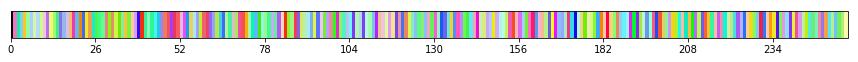

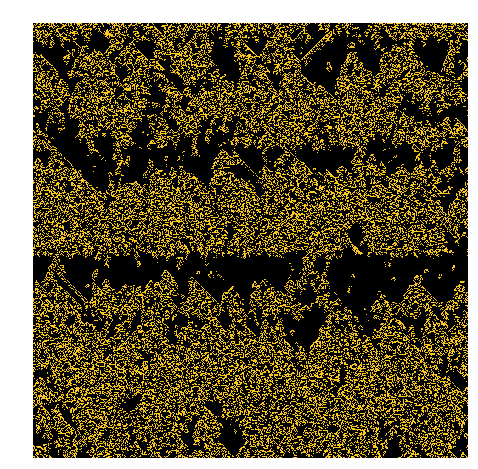

In [11]:
my_dpi=96
my_cmap = rand_cmap(257, type='bright', first_color_black=True, last_color_black=False)

fig, ax = plt.subplots(figsize=((3*256)/my_dpi, (3*256)/my_dpi), dpi=my_dpi, frameon=False)
ax.axis('off')
# mat = ax.matshow(cgrid, cmap=my_cmap, vmin=0.01, vmax=257)  # was vmax = LEN+1
mat = ax.matshow(cgrid, cmap=my_cmap, vmin = 0, vmax = 56)
plt.show()